Taking a closer look at the TESS data for HD 124011

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec

import lightkurve as lk


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [12]:
search_result = lk.search_lightcurve('TIC 166527623')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,166527623,0.0
1,TESS Sector 38,2021,SPOC,120,166527623,0.0
2,TESS Sector 64,2023,SPOC,20,166527623,0.0
3,TESS Sector 64,2023,SPOC,120,166527623,0.0
4,TESS Sector 11,2019,TESS-SPOC,1800,166527623,0.0
5,TESS Sector 38,2021,TESS-SPOC,600,166527623,0.0
6,TESS Sector 64,2023,TESS-SPOC,200,166527623,0.0
7,TESS Sector 11,2019,QLP,1800,166527623,0.0
8,TESS Sector 38,2021,QLP,600,166527623,0.0


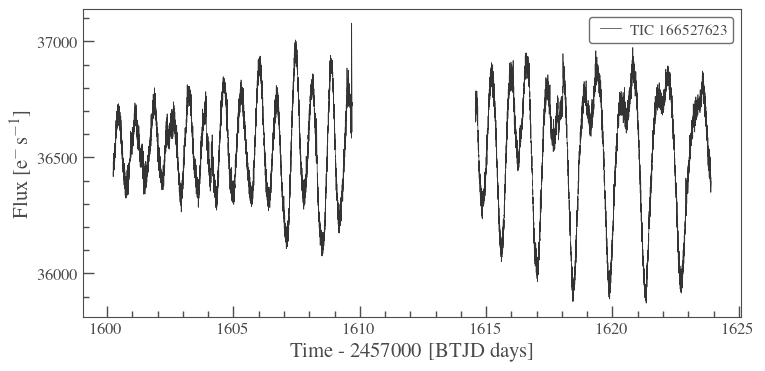

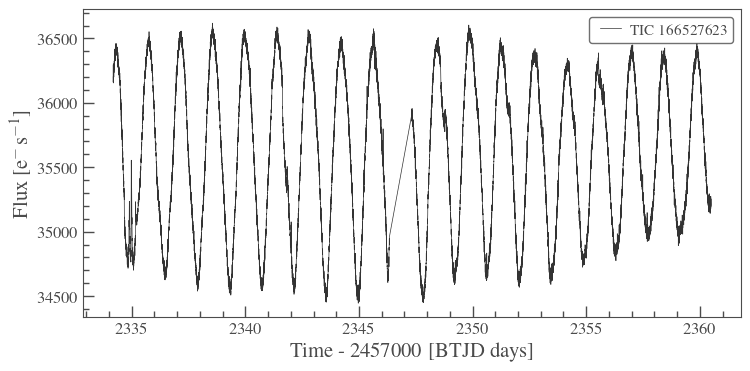

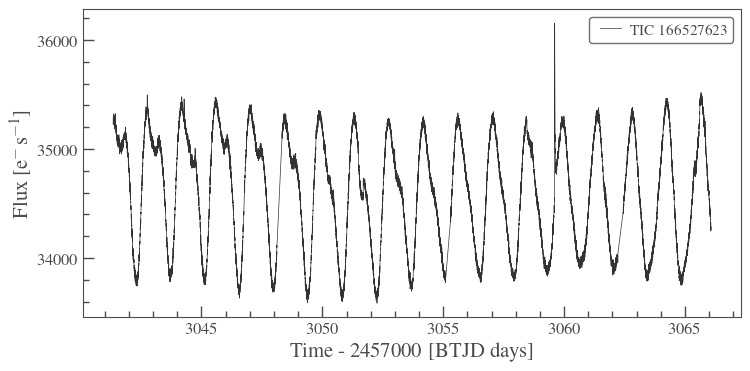

In [13]:
for sr in [search_result[0], search_result[1], search_result[3]]:
    lc = sr.download(download_dir='mastDownload/')
    lc.plot()

0.7085028077139967 d
1.415925355006897 d
1.415626244417666 d


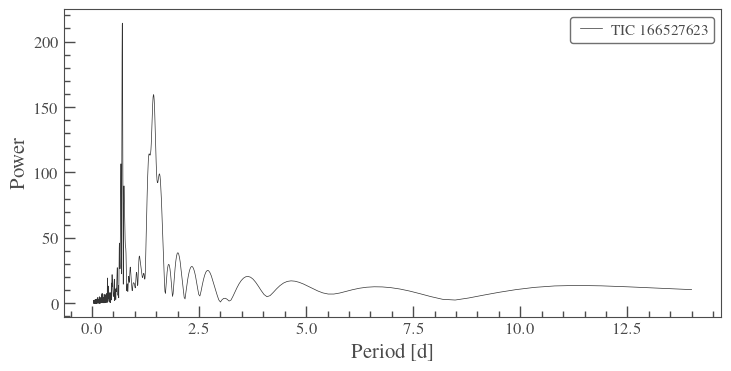

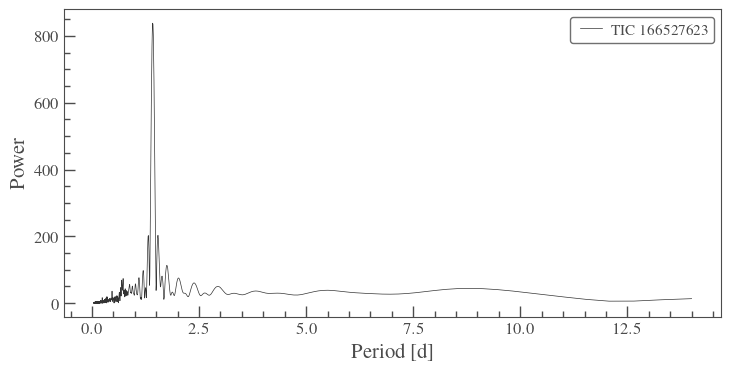

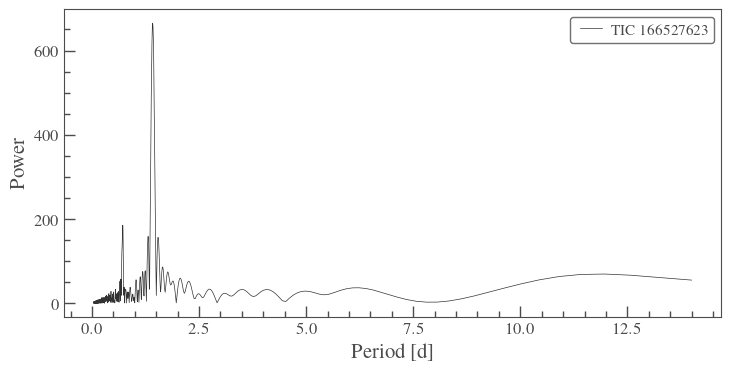

In [14]:
for sr in [search_result[0], search_result[1], search_result[3]]:
    lc = sr.download(download_dir='mastDownload/')
    # lc.plot()
    lc.flux = lc.flux.value #something up with lk that means I need to do this
    lc.flux_err = lc.flux_err.value
    lcn=lc.normalize()
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=1*u.hour, maximum_period=14*u.day)
    print(pg.period_at_max_power)

    pg.plot()

0.7085028077139967 d
1.4170056154279933 d
1.415626244417666 d
1.415626244417666 d
0.04167070600911447 d
0.04167070600911447 d


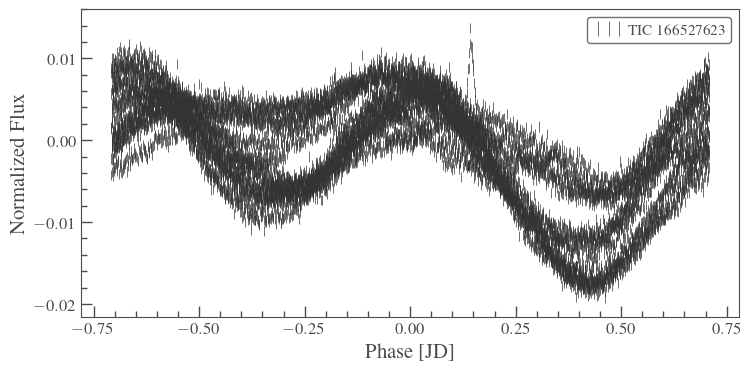

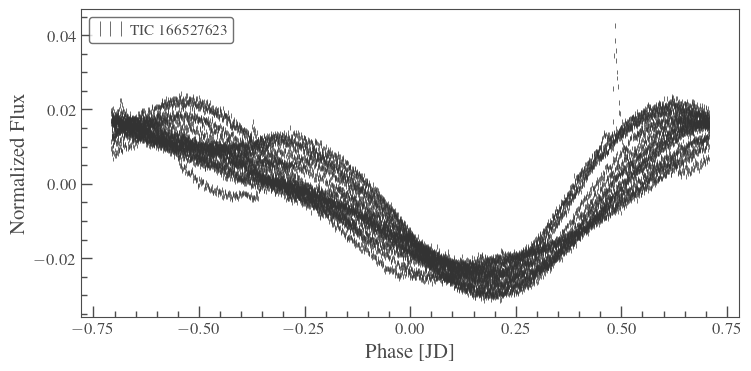

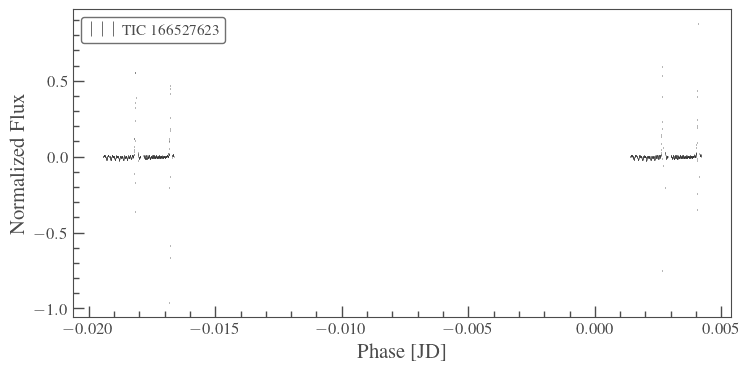

In [5]:
for i, sr in enumerate([search_result[0], search_result[3], search_result[7]]):
    lc = sr.download(download_dir='mastDownload/')
    # lc.plot()
    lc.flux = lc.flux.value #something up with lk that means I need to do this
    lc.flux_err = lc.flux_err.value
    lcn=lc.normalize()
    lcn = lcn -1
    pg = lcn.to_periodogram(oversample_factor=10,minimum_period=1*u.hour, maximum_period=14*u.day)
    print(pg.period_at_max_power)
    period = pg.period_at_max_power


    # pg.plot()

    if i == 0:
        period *=2
        epoch = lc.time[0]
    print(period)
    
    if i == 1:
        lc2 = lcn

    lcf = lcn.fold(period, epoch_time=epoch)#.bin(10*u.min)
    lcf.errorbar()

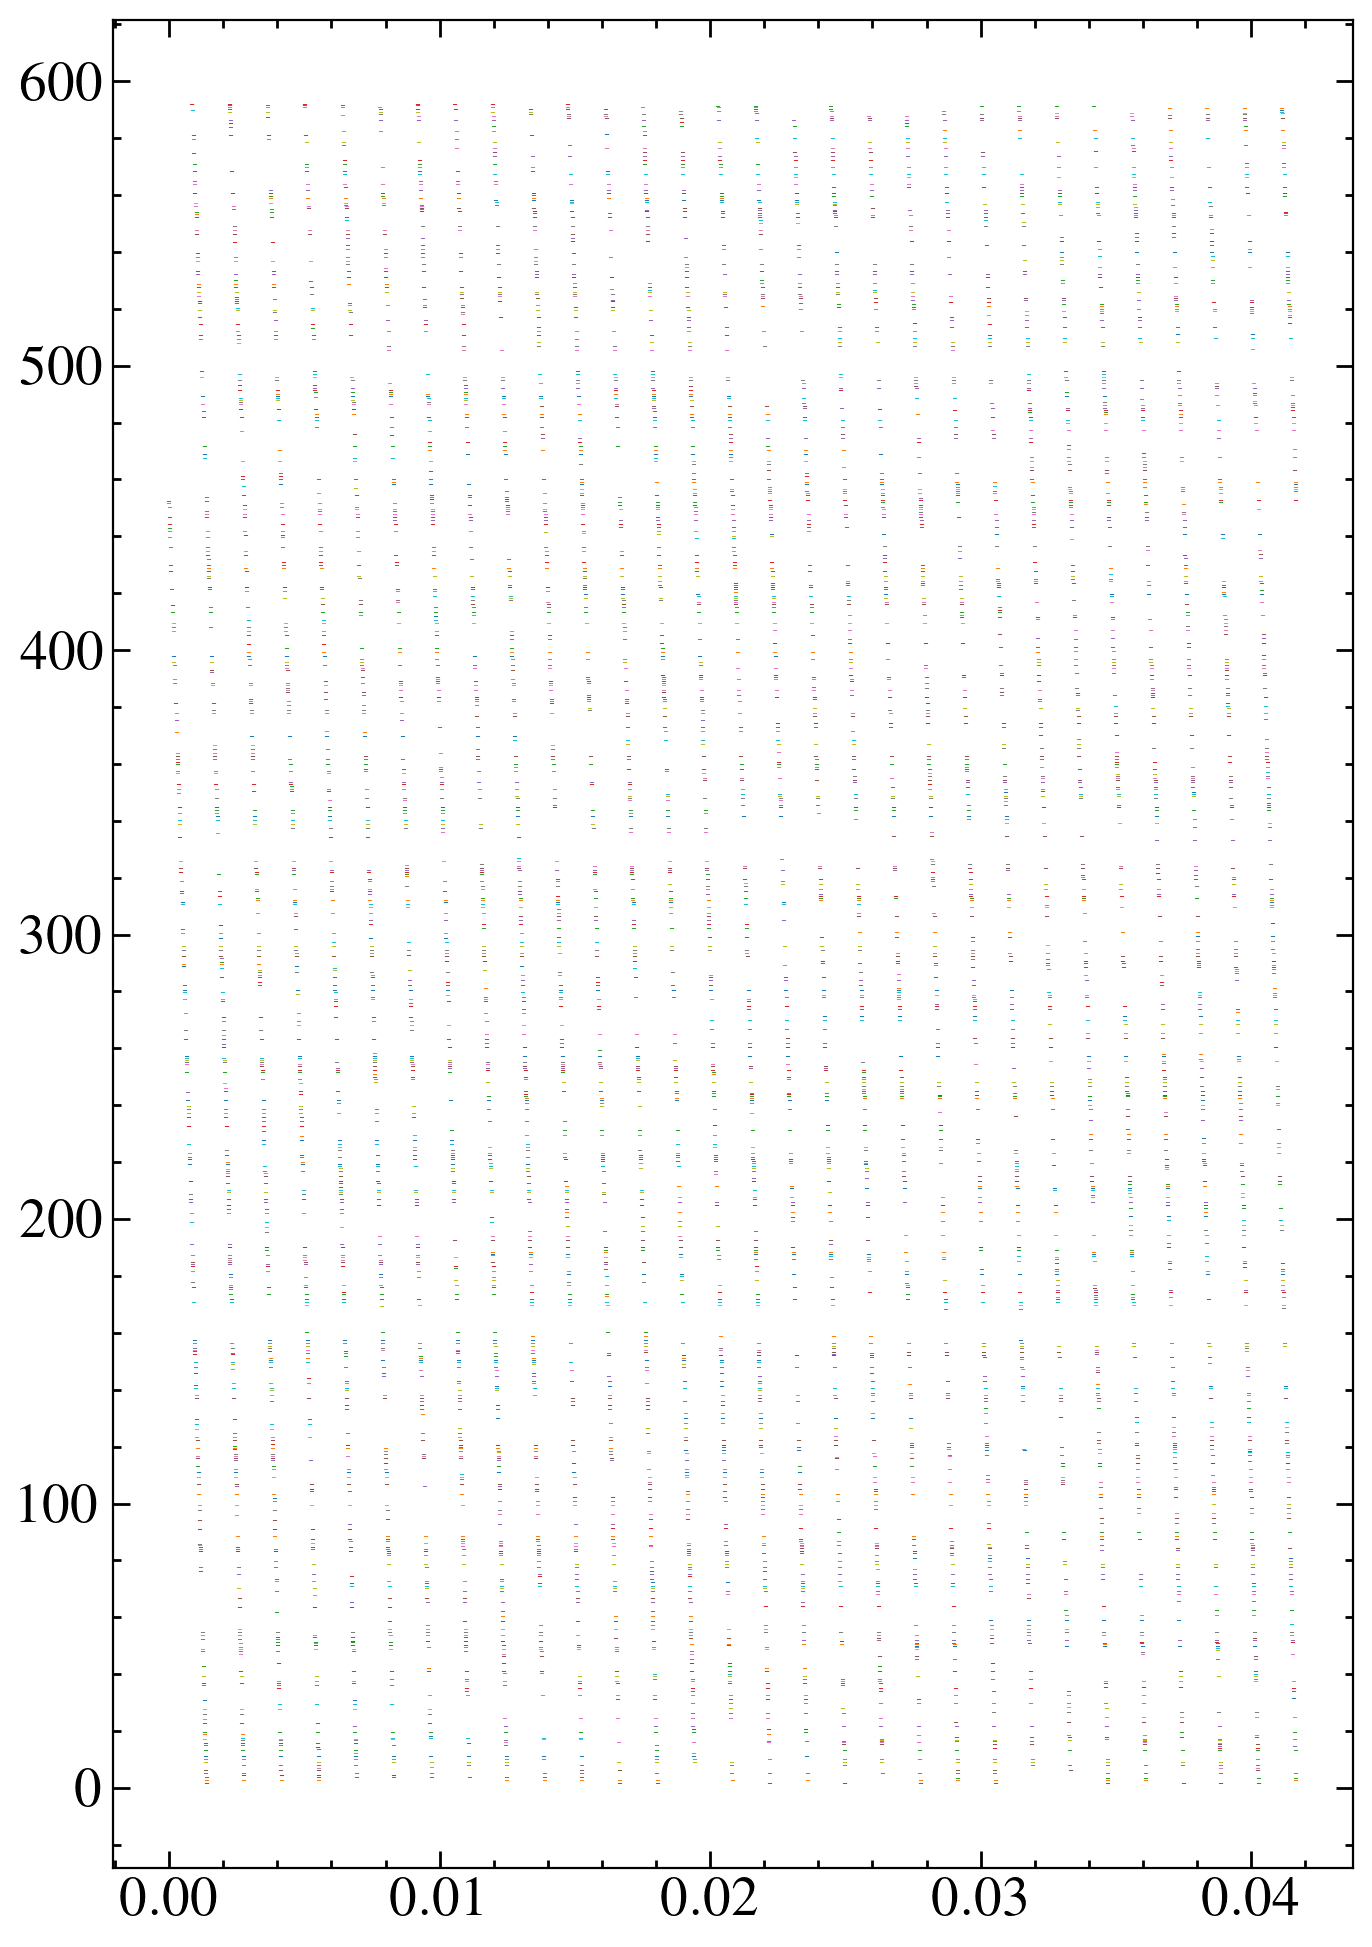

In [6]:
lc2= lc2.remove_nans()
t0 = lc2.time[0]
n = 0
fig, ax = plt.subplots(figsize=(8, 12))

while t0 < lc2.time[-1]:
    mask = (lc2.time > t0) & (lc2.time < t0+period)
    # lci = lc2[mask]
    t, f, e = np.array(lc2.time[mask].value), np.array(lc2.flux[mask]), np.array(lc2.flux_err[mask])
    f*=100
    e*=100
    plt.errorbar(t-t0.value, f+n, yerr=e, ls='None')
    
    t0 += period
    n +=1

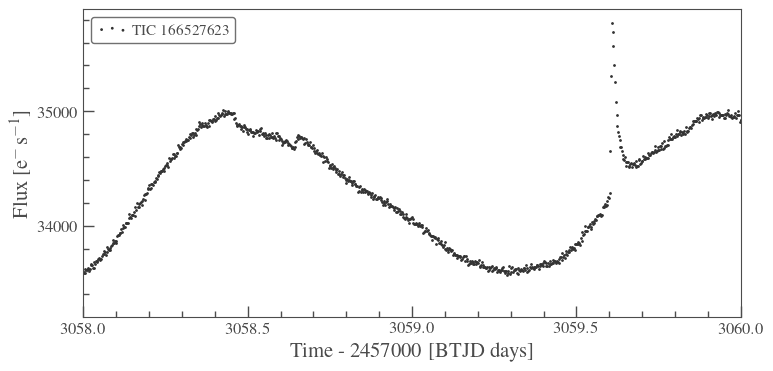

In [7]:
for sr in [search_result[6]]:
    lc = sr.download(download_dir='mastDownload/')
    lc.scatter()
    plt.xlim(3058, 3060)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

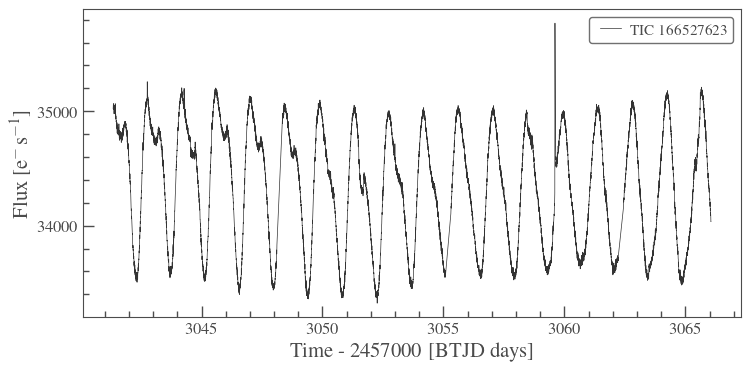

In [8]:
lc.plot()

3054.5776842613504
1.4153657427408952 d
1.4177150869006407 d


<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

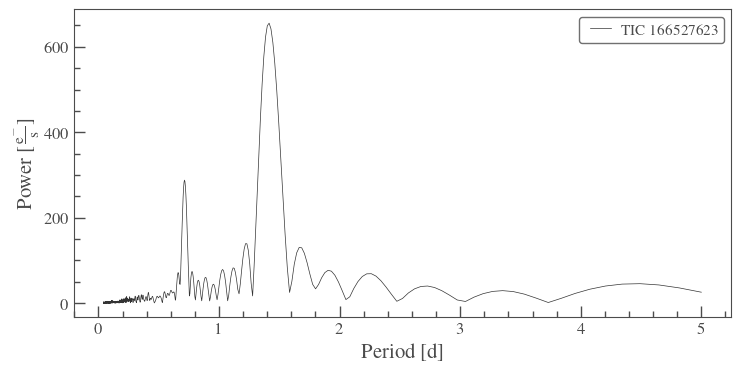

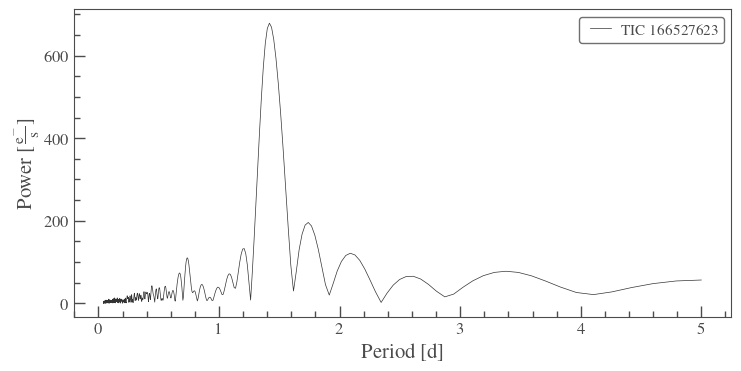

In [9]:
mid = (lc.time[0].value + lc.time[-1].value)/2
print(mid)
lc1 = lc[lc.time.value < mid]
lc2 = lc[lc.time.value >= mid]

pg1 = lc1.to_periodogram(oversample_factor=10,minimum_period=1*u.hour, maximum_period=5*u.day)
print(pg1.period_at_max_power)

pg1.plot()

pg2 = lc2.to_periodogram(oversample_factor=10,minimum_period=1*u.hour, maximum_period=5*u.day)
print(pg2.period_at_max_power)

pg2.plot()

In [10]:
search_result = lk.search_lightcurve('TIC 278892590 ')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 12,2016,K2,60,ktwo246199087,0.0
1,K2 Campaign 12,2016,K2,1800,ktwo246199087,0.0
2,K2 Campaign 19,2018,K2,60,ktwo246199087,0.0
3,K2 Campaign 19,2018,K2,1800,ktwo246199087,0.0
4,K2 Campaign 12,2016,EVEREST,1800,ktwo246199087,0.0
5,K2 Campaign 12,2016,K2SFF,1800,ktwo246199087,0.0
6,K2 Campaign 19,2018,K2SFF,1800,ktwo246199087,0.0
7,TESS Sector 70,2023,SPOC,20,278892590,0.0
8,TESS Sector 70,2023,SPOC,120,278892590,0.0
